# Voronoi Polygon

In this project, we employ Voronoi polygons, also known as Thiessen polygons in hydrology, to process and account for the geospatial distribution of rainfall. This method allows us to convert point rainfall data from irregularly spaced rain gauge stations into an areal average rainfall for a given watershed. A Voronoi polygon defines the area around a rain gauge that is closer to it than to any other gauge. By computing these polygons, we can effectively spatialize the precipitation data. This processed rainfall data is a critical input for our machine learning model, which aims to estimate the Time of Concentration ($T 
_c$) and Storage Coefficient ($R$) for ungauged watersheds. The model will be trained on the geomorphological characteristics of delineated watersheds and their corresponding spatially averaged rainfall, enabling better prediction of hydrological responses.

This notebook derives the Thiessen Polygons, clips area of contribution of each precipitation station in each delineated watershed, and line up precipitation data with streamflow data, preparing to storm event selection. 

For deriving Thiessen Polygons and computing area for each watershed, the following steps will be taken:

1. Project ranifall and the study region boundary ton Albers Equal Area Conic (an equal-area projection), EPSG 9822
2. Derive Thiessen Polygons 
3. Analyze Watershed by Watershed: 
    - Identify its predominant UTM zone
    - Take the full set of Thiessen polygons and the wastershed boundary and reproject both to that watershd's predominant UTM zone
    - Clip the reprojected Thiessen Polygons to the reprojected watershed boundary.
    - Perfom area calculations

In [168]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import json
from tqdm.notebook import tqdm

In [65]:
# Set paths
project_root_path = Path.cwd().parent.parent
wsdir = project_root_path / 'data/silver/geo/gpkg/watersheds'
map_style_path = project_root_path / 'config/map_style.json'

In [66]:
# Custom Modules
sys.path.append(str(project_root_path / 'src'))
from preprocessing.thiessen_polygons import derive_thiessen_polygons

In [227]:
# Define help function
import re
import ast
from typing import Any

def parse_np_float64_string(s: str) -> Any:
    """
    Safely parse a string representing a list/dict containing np.float64 calls.
    It replaces np.float64(NUMBER) with NUMBER and evaluates the cleaned string.

    Parameters
    ----------
    s : str
        The string to parse.

    Returns
    -------
    Any
        The resulting Python object (list, dict, etc.).
    """
    # Replace np.float64(NUMBER) with NUMBER
    cleaned = re.sub(r'np\.float64\(([^)]+)\)', r'\1', s)
    # Safely parse as Python literal
    return ast.literal_eval(cleaned)

## Load Data

In [67]:
# File paths
geomorpho_char_path = project_root_path / 'data/gold/tabular/geomorphological_characteristics.csv'
vector_watersheds_dir = project_root_path  / 'data/gold/geo/gpkg/watersheds'
vector_study_area_path = project_root_path / 'data/silver/geo/gpkg/study_area.gpkg'
vector_ppt_path = project_root_path / 'data/silver/geo/gpkg/study_area_ppt_stn.gpkg'

In [68]:
# Load Data
stnids = pd.read_csv(geomorpho_char_path, dtype={'Station ID':str})['Station ID'].tolist()
epsg = 'EPSG:9822'
watersheds_dict = dict()
for stnid in stnids:
    ws_path = vector_watersheds_dir / f'catchment_{stnid}.gpkg'
    if ws_path.exists():
        watersheds_dict[stnid] = gpd.read_file(ws_path)
print(f'Loaded {len(watersheds_dict)} watersheds from {vector_watersheds_dir}')

study_area_gdf = gpd.read_file(vector_study_area_path)
ppt_gdf = gpd.read_file(vector_ppt_path).to_crs(epsg)

print(f'Study area CRS: {study_area_gdf.crs}')
print(f'PPT stations CRS: {ppt_gdf.crs}')

Loaded 508 watersheds from /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/gold/geo/gpkg/watersheds
Study area CRS: EPSG:4269
PPT stations CRS: EPSG:9822


/var/folders/6x/tz4_svyx1mv9mc68z3jl0_s00000gn/T/ipykernel_3819/87141545.py:45: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', frameon=True)


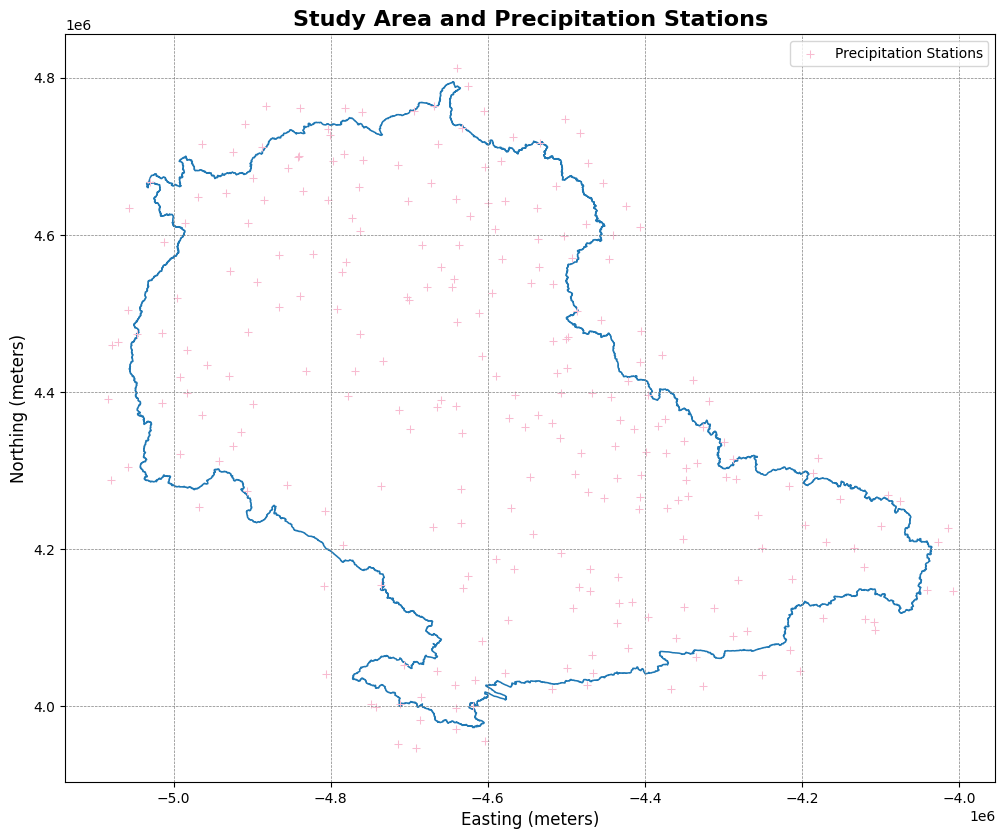

In [69]:
# --- 1. Load map style ---
try:
    with open(map_style_path, 'r') as f:
        map_style = json.load(f).get('map_styles', {})
    background_color = '#ffffff' 
except FileNotFoundError:
    print("Warning: 'map_style.json' not found. Using default styles.")
    background_color = '#ffffff'

# --- 2. Prepare Data ---
study_area_proj = study_area_gdf.to_crs(epsg)

# --- 3. Create the Plot ---
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor(background_color)

# Plot the study area boundary.
study_area_proj.plot(
    ax=ax,
    facecolor= 'none',      
    edgecolor=map_style.get('watershed_boundary').get('color'),  
    linewidth=1.1, 
    label='Study Area'
)

# Plot the precipitation station points on top.
ppt_gdf.plot(
    ax=ax,
    marker=map_style.get('precipitation_station').get('shape'),
    color=map_style.get('precipitation_station').get('fill'),     
    markersize=30,
    linewidth=0.75,
    alpha=1,
    label='Precipitation Stations'
)


# --- 4. Customize the Plot ---
# Add titles and labels for clarity.
ax.set_title('Study Area and Precipitation Stations', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (meters)', fontsize=12)
ax.set_ylabel('Northing (meters)', fontsize=12)

# Add a legend to identify the layers.
ax.legend(loc='upper right', frameon=True)

# Add a grid for better spatial reference.
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Ensure the aspect ratio is equal to prevent stretching the map.
ax.set_aspect('equal', adjustable='box')


# --- 5. Display the Map ---
# Show the final plot.
plt.show()


## Derive Thiessen Polygons

In [70]:
print('Projected Study Area CRS:', study_area_proj.crs)
print('Projected PPT Stations CRS:', ppt_gdf.crs)
print('PPT columns:', ppt_gdf.columns.tolist())

Projected Study Area CRS: EPSG:9822
Projected PPT Stations CRS: EPSG:9822
PPT columns: ['index', 'StnID', 'Lat', 'Lon', 'Elev', 'State/Province', 'Name', 'WMO_ID', 'Sample_Interval (min)', 'UTC_Offset', 'POR_Date_Range', 'PCT_POR_Good', 'Last_Half_POR', 'PCT_Last_Half_Good', 'Last_Qtr_POR', 'PCT_Last_Qtr_Good', 'geometry']


In [86]:
thiessen_poly = derive_thiessen_polygons(ppt_gdf, study_area_proj, 'StnID')

In [72]:
thiessen_poly.head()

,StnID,geometry
0,USC00111302,"POLYGON ((-4868970.543 4611542.48, -4910973.43..."
1,USC00111329,"POLYGON ((-4762408.791 4725865.047, -4732391.9..."
2,USC00111664,"POLYGON ((-4832870.352 4678363.426, -4862522.1..."
3,USC00112140,"POLYGON ((-4632560.005 4703077.494, -4641129.3..."
4,USC00112353,"POLYGON ((-4946487.753 4616026.948, -5003729.9..."


In [74]:
# Save the Thiessen polygons to a GeoPackage file.
thiessen_poly_path = project_root_path / 'data/gold/geo/gpkg/thiessen_polygons.gpkg'
thiessen_poly.to_file(thiessen_poly_path, driver='GPKG')
print(f'Thiessen polygons saved to {thiessen_poly_path}')

Thiessen polygons saved to /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/gold/geo/gpkg/thiessen_polygons.gpkg


In [77]:
thiessen_poly = gpd.read_file(thiessen_poly_path)
print(f'Thiessen polygons CRS: {thiessen_poly.crs}')

Thiessen polygons CRS: EPSG:9822


In [75]:
watersheds_gdf_project = gpd.GeoDataFrame()

for ws_gdf in watersheds_dict.values():
    ws_gdf = ws_gdf.to_crs(epsg)
    watersheds_gdf_project = pd.concat([watersheds_gdf_project, ws_gdf], ignore_index=True)

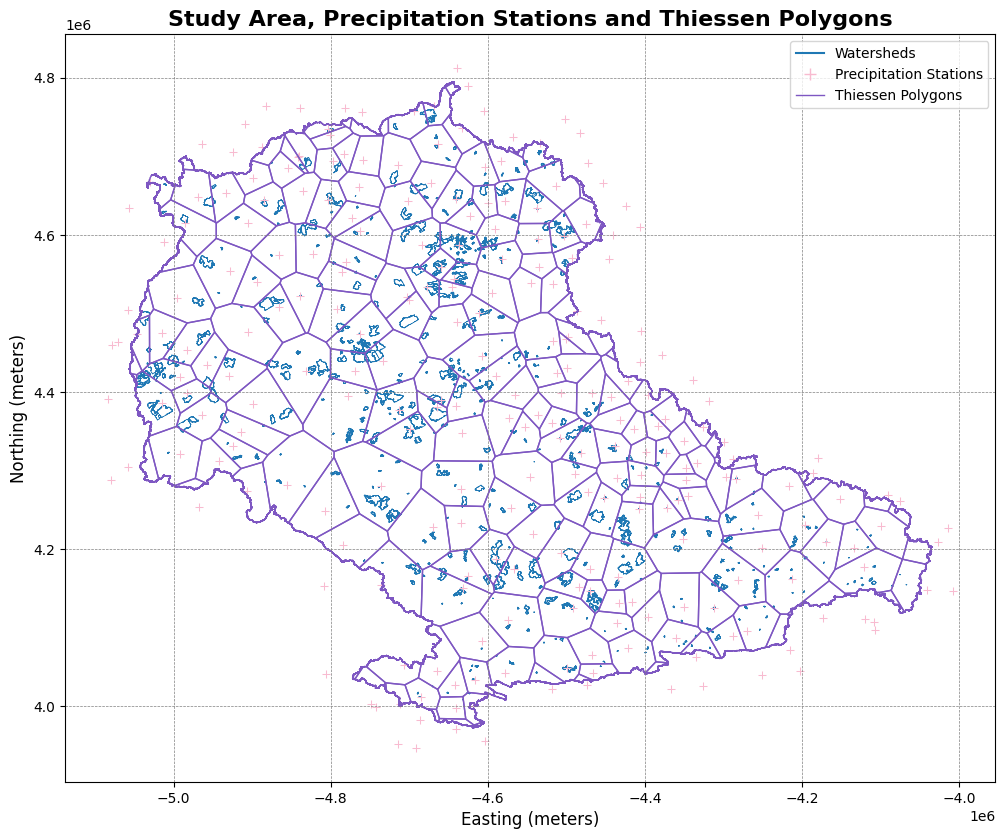

In [76]:

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_facecolor(background_color)

# Plot the study area boundary.
watersheds_gdf_project.plot(
    ax=ax,
    facecolor= 'none',      
    edgecolor=map_style.get('watershed_boundary').get('color'),  
    linewidth=0.5, 
    label='Study Area'
)

# Plot the precipitation station points on top.
ppt_gdf.plot(
    ax=ax,
    marker=map_style.get('precipitation_station').get('shape'),
    color=map_style.get('precipitation_station').get('fill'),     
    markersize=30,
    linewidth=0.75,
    alpha=1,
    label='Precipitation Stations'
)

# Thiessen polygons
thiessen_poly.plot(
    ax=ax,
    facecolor='none',
    edgecolor=map_style.get('thiessen_polygon').get('color'),
    linewidth=map_style.get('thiessen_polygon').get('width'),
    label='Thiessen Polygons'
)


# --- 4. Customize the Plot ---
# Add titles and labels for clarity.
ax.set_title('Study Area, Precipitation Stations and Thiessen Polygons', fontsize=16, fontweight='bold')
ax.set_xlabel('Easting (meters)', fontsize=12)
ax.set_ylabel('Northing (meters)', fontsize=12)

# Manually create legend handles
legend_elements = [
    Line2D([0], [0], color=map_style.get('watershed_boundary').get('color'), lw=1.5, label='Watersheds'),
    Line2D([0], [0], marker=map_style.get('precipitation_station').get('shape'), color=map_style.get('precipitation_station').get('fill'), label='Precipitation Stations', linestyle='None', markersize=8),
    Line2D([0], [0], color=map_style.get('thiessen_polygon').get('color'), lw=map_style.get('thiessen_polygon').get('width'), label='Thiessen Polygons')
]

# Add the custom legend to the plot
ax.legend(handles=legend_elements, loc='upper right')

# Add a grid for better spatial reference.
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Ensure the aspect ratio is equal to prevent stretching the map.
ax.set_aspect('equal', adjustable='box')


# --- 5. Display the Map ---
# Show the final plot.
plt.show()


As seen from above, the most of watershed is too small in relation to the cover area of precipitation station. For most of the watersheds the spatial distribution of rainfall as measured by the grid of precipitation stations available might be negligible. Next we evaluate how far each watershed centroid is from each precipitation gauge station and how many precipitation stations contributes to the watershed area. Some of watersheds, small tiny of some polygon covers the area, making it relevant to the spatial distribution. Thiessen polygon covering 5% or less of watersheds will be dropped. 

In [85]:
# Intersecting Thiessen polygons with watersheds
intersecting_data = gpd.sjoin(watersheds_gdf_project, thiessen_poly, how="left", predicate="intersects")
intersecting_data = intersecting_data.rename(columns={'StnID': 'ppt_stn_id'})
intersecting_data.head()

,stnid,pour_point_nad83,snapped_pour_point_nad83,distance_between_points_m,accumulation_value,geometry,index_right,ppt_stn_id
0,03314000,POINT (-86.38054746240252 36.89532216505766),POINT (-86.38068259750645 36.895179522394244),19.884212,50,"POLYGON ((-4927283.464 4442449.69, -4927308.45...",89,USC00157215
0,03314000,POINT (-86.38054746240252 36.89532216505766),POINT (-86.38068259750645 36.895179522394244),19.884212,50,"POLYGON ((-4927283.464 4442449.69, -4927308.45...",190,USC00407359
1,03431060,POINT (-86.71904807055569 36.11757648113722),POINT (-86.71918320565962 36.11743383847381),19.955516,50,"POLYGON ((-5010199.535 4422044.804, -5010226.3...",189,USC00406806
2,03083500,POINT (-79.80669670546334 40.24022296584883),POINT (-79.80599850723374 40.239524767629774),97.648123,50,"POLYGON ((-4295298.677 4153046.024, -4295285.2...",162,USC00361726
2,03083500,POINT (-79.80669670546334 40.24022296584883),POINT (-79.80599850723374 40.239524767629774),97.648123,50,"POLYGON ((-4295298.677 4153046.024, -4295285.2...",169,USC00366111


In [200]:
ppt_gdf

,index,StnID,Lat,Lon,Elev,State/Province,Name,WMO_ID,Sample_Interval (min),UTC_Offset,POR_Date_Range,PCT_POR_Good,Last_Half_POR,PCT_Last_Half_Good,Last_Qtr_POR,PCT_Last_Qtr_Good,geometry
0,11,USC00011099,34.9809,-85.8101,203.3,AL,BRIDGEPORT 5 NW,NaN,15,-6,19821101-20250109,87.2%,20031206-20250109,93.7%,20140623-20250109,96.2%,POINT (-5079787.918 4288267.677)
1,1540,USC00406162,35.2243,-85.8414,563.9,TN,MONTEAGLE,NaN,15,-6,19820601-20250108,89.8%,20030920-20250108,88.3%,20140515-20250108,94.9%,POINT (-5057835.804 4304567.718)
2,1535,USC00405187,35.4140,-86.8086,239.9,TN,LEWISBURG EXP STA,NaN,15,-6,19710501-20250117,81.8%,19980310-20250117,71.2%,20110814-20250117,61.8%,POINT (-5084098.46 4391716.946)
3,1551,USC00408540,35.6763,-84.8547,230.1,TN,SPRING CITY,NaN,15,-5,20030501-20250106,92.8%,20140304-20250106,95.4%,20190805-20250106,90.9%,POINT (-4968263.563 4253110.047)
4,1525,USC00401587,35.7553,-87.4261,201.2,TN,CENTERVILLE WATER PL,NaN,15,-6,19820401-20060726,83.6%,19940529-20060726,75.8%,20000626-20060726,69.4%,POINT (-5078901.189 4459496.696)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,506,USC00128992,41.5436,-87.0319,264.9,IN,VALPARAISO 5NNE,NaN,15,-6,20051203-20140501,84.1%,20100215-20140501,99.9%,20120324-20140501,99.8%,POINT (-4502228.35 4747861.83)
256,480,USC00123418,41.5575,-85.8825,266.7,IN,GOSHEN 3SW,NaN,15,-5,19840101-20250113,95.8%,20040708-20250113,96.5%,20141011-20250113,99.9%,POINT (-4452746.21 4665711.063)
257,487,USC00124837,41.6116,-86.7297,246.6,IN,LAPORTE,NaN,15,-6,19840101-20250107,80.7%,20040705-20250107,79.1%,20141006-20250107,89.8%,POINT (-4483133.082 4729765.202)
258,485,USC00124730,41.6474,-85.4121,274.3,IN,LAGRANGE,NaN,15,-5,19710501-20151202,77.1%,19930816-20151202,68.6%,20041008-20151202,48.3%,POINT (-4424151.04 4637082.573)


In [239]:
# Compute area contribution of each Thiessen polygon to the watershed
updated_watersheds = []
intersecting_thiessen_list = []
for wid, watershed in tqdm(watersheds_dict.items(), desc="Computing area contibution of thiessen polygon for each watershed", total=len(watersheds_dict)):
    watershed_crs = watershed.crs
    watershed_area = watershed.geometry.area.sum()
    ppt_stnid = intersecting_data[intersecting_data['stnid'] == wid]['ppt_stn_id'].to_list()
    thiessen_poly_subset = thiessen_poly[thiessen_poly['StnID'].isin(ppt_stnid)]
    thiessen_poly_subset = thiessen_poly_subset.to_crs(watershed_crs)
    intersecting_thiessen = gpd.overlay(watershed, thiessen_poly_subset, how='intersection')
    intersecting_thiessen['area'] = intersecting_thiessen.geometry.area
    intersecting_thiessen_list.append(intersecting_thiessen)
    intersecting_details  = []

    for idx, row in intersecting_thiessen.iterrows():
        ppt_id = row['StnID']
        area = row['area']
        relative_area = area / watershed_area

        ppt_stn_subset = ppt_gdf[ppt_gdf['StnID'] == ppt_id].to_crs(watershed_crs)
        thiessen_centroid = row.geometry.centroid

        intersecting_details.append({
            'ppt_stnid': ppt_id,
            'area': area,
            'relative_area': relative_area, 
            'thiessen_centroid_distance_to_ppt_stn': thiessen_centroid.distance(ppt_stn_subset.geometry.iloc[0])
        })
        
        intersecting_details_len = len(intersecting_details)
        if intersecting_details_len > 1:
            small_areas = [small_area for small_area in intersecting_details if small_area['relative_area'] <= 0.05]    

            if small_areas:
                # Drop small areas
                small_areas_len = len(small_areas)
                small_areas_total_area = sum(small_area['area'] for small_area in small_areas)

                # Equally distribute the small areas' total area to the remaining larger areas
                small_areas_partial_contribution = small_areas_total_area / small_areas_len
                large_areas = [area['area'] + small_areas_partial_contribution for area in intersecting_details if area['relative_area'] > 0.05]
                
                # Update the intersecting details with the new areas
                final_intersecting_details = []
                for thiessen in intersecting_details:
                    if thiessen['relative_area'] > 0.05:
                        thiessen['area'] = large_areas.pop(0)
                        thiessen['relative_area'] = thiessen['area'] / watershed_area

                        final_intersecting_details.append(thiessen)

                intersecting_details = final_intersecting_details
                
    watershed['intersecting_ppt_info'] = None  # sets dtype to object
    watershed.at[watershed.index[0], 'intersecting_ppt_info'] = intersecting_details
    updated_watersheds.append(watershed)

Computing area contibution of thiessen polygon for each watershed:   0%|          | 0/508 [00:00<?, ?it/s]

In [236]:
updated_watersheds[2]['intersecting_ppt_info'].iloc[0]

[{'ppt_stnid': 'USC00361726',
  'area': 6862326.963494706,
  'relative_area': np.float64(0.18527316761671084),
  'thiessen_centroid_distance_to_ppt_stn': 24086.25962298222},
 {'ppt_stnid': 'USC00366111',
  'area': 30176641.235566583,
  'relative_area': np.float64(0.8147268323832889),
  'thiessen_centroid_distance_to_ppt_stn': 20712.449146378724}]

In [242]:
# Save the updated watersheds with intersecting Thiessen polygon information
updated_watersheds_dir = project_root_path / 'data/gold/geo/gpkg/watersheds_with_thiessen_info'
updated_watersheds_dir.mkdir(parents=True, exist_ok=True)
for ws in tqdm(updated_watersheds, desc="Saving updated watersheds", total=len(updated_watersheds)):
    ws_id = ws['stnid'].loc[0]
    ws_path = updated_watersheds_dir / f'catchment_{ws_id}.gpkg'
    ws.to_file(ws_path, driver='GPKG')


Saving updated watersheds:   0%|          | 0/508 [00:00<?, ?it/s]

In [240]:
updated_watersheds[2]['intersecting_ppt_info'].iloc[0]

[{'ppt_stnid': 'USC00361726',
  'area': 6862326.963494706,
  'relative_area': np.float64(0.18527316761671084),
  'thiessen_centroid_distance_to_ppt_stn': 24086.25962298222},
 {'ppt_stnid': 'USC00366111',
  'area': 30176641.235566583,
  'relative_area': np.float64(0.8147268323832889),
  'thiessen_centroid_distance_to_ppt_stn': 20712.449146378724}]

# ADD TO THE MAP BELOW THE PRECIPITATION STATION TO VERIFY DISTANCE

<Axes: >

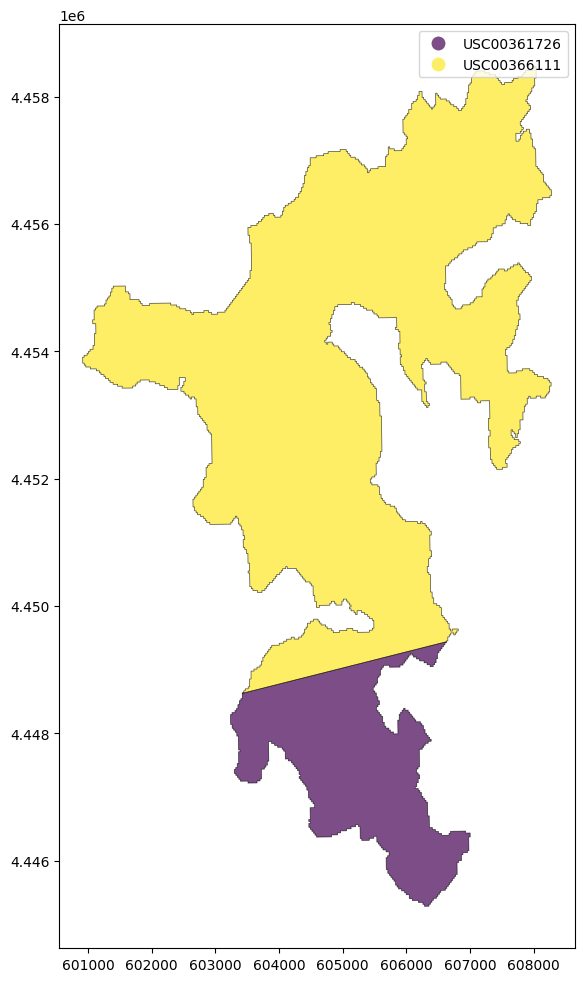

In [241]:
fig, ax = plt.subplots(figsize=(12, 12))

intersecting_thiessen_list[2].plot(
    ax=ax,
    column='StnID',
    cmap='viridis',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.7
)